# 加载

In [1]:
import plotly.graph_objects as go
import datetime
from datetime import datetime
import random
import calendar
import time
import seaborn as sns
import tensorflow as tf
from sklearn import svm
from subprocess import call
from scipy import signal
from sklearn import tree
import sklearn
from matplotlib.lines import Line2D
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
from numpy import linalg
from IPython.display import Image
import os
import graphviz
import sys
import csv
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
import numpy as np
import warnings
from sklearn.tree import export_graphviz
from sklearn import datasets
warnings.filterwarnings("ignore")
import math
import operator
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import stats
from copy import deepcopy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate
from WindPy import w
from numpy import exp, array, random, dot
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# 函数

## 神经网络

In [2]:
#激活函数及坡度
def sig(x):
    return 1 / (1 + exp(-x))

def sig_drv(x):
    return x * (1-x)

#生成初始神经网络
def gen_layer(x,y,nnum):
    res = [2 * random.random((len(x[0]), nnum[0])) - 1]
    if len(nnum) > 1:
        for i in range(1,len(nnum)):
            res.append(2 * random.random((nnum[i-1], nnum[i])) - 1)
    res.append(2 * random.random((nnum[-1], len(y[0]))) - 1)
    return res

#输入结果
def calc(x, nn):
    res = []
    for i in range(len(nn)):
        if i == 0:
            res.append(sig(dot(x, nn[i])))
        else:
            res.append(sig(dot(res[-1], nn[i])))
    return res

#训练
def correct(x, y, nnum, time,prt):
    layer = gen_layer(x,y,nnum)
    for j in range(time):
        res = calc(x, layer)
        det = []
        err = []
        adj = []
        for i in range(len(layer)-1,-1,-1):
            if i == len(layer)-1:
                err.append(y - res[-1])
                det.append(err[0] * sig_drv(res[-1]))
            else:
                err.append(det[-1].dot((layer[i+1]).T))
                det.append(err[-1] * sig_drv(res[i]))
        
        det = det[::-1]
        for i in range(len(det)):
            if i == 0:
                adj.append((x.T).dot(det[i]))
            else:
                adj.append((res[i-1].T).dot(det[i]))        
        for i in range(len(layer)):
            layer[i] += adj[i]
    if prt:
        print('神经层',layer)
    return layer

## !!!!!!!!!!!多组数据加工

In [3]:
#l选取数据时长
def data_pro(data,l):
    df = []
    for i in range(l-1,len(date)):
        temp = []
        for j in range(len(data)):
            i = int(i)
            j = int(j)
            
            #选取第j组数据
            il = data[j][i-l+1:i+1]
            
            #价格与移动平均线的关系 
            temp.append(-(-1) ** (data[j][i] >= np.mean(il)))    
            
            #ROC 
            temp.append(il[-1]/(il[-2]+10e-4)-1)
            temp.append(il[-1]/(il[-4]+10e-4)-1)
            temp.append(il[-1]/(il[-7]+10e-4)-1)
            temp.append(il[-1]/(il[0]+10e-4)-1)
            
            #极值差距 
            temp.append(((max(il)-min(il))/np.mean(il)))
            
            #反转频率 
            spike = 0
            dirc = -(-1) ** (il[1] > il[0]) 
            for k in range(1,l):
                spike += (-(-1) ** (il[k] > il[k-1]) != dirc)
                dirc = -(-1) ** (il[k] > il[k-1])
            temp.append(spike)
            
            #当前指数水平
            temp.append(il[-1]/np.mean(il[6:])-1)
    
        df.append(temp)
    return df

## 预测结果评估

In [4]:
#准确度计算
def acc(res,ans):
    if len(res) != len(ans):
        return('准确度数据长度不同')
    else:
        return round(sum(np.array(res) == np.array(ans))/ len(res),2)

        

#收益率计算
def profit(data, ud):
    if len(data) != len(ud):
        return('收益率数据长度不同')
    money = 1
    num = 0
    prt = 0   #显示买卖记录
    m2y = 1   #是否年化收益
    for i in range(len(data)):
        if ud[i] == 1 and num == 0:
            if prt:
                print('in', date[11:][i], 'money', money, 'num', num, 'price', data[i])
 
            num = money/(data[i]+10e-6)
            money = 0
        if ud[i] == -1 and money == 0 and data[i] != 0:
            if prt:
                print('out', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            money = num * data[i]
            num = 0
    if prt:
        print('结果',money+num*data[-1])
    if m2y:
        return (money+num*data[-1]) ** (1/len(data)*12)-1
    return money+num*data[-1]-1

#错误区间占比
def wrong_div(dat, ud):
    if len(dat) != len(ud):
        return('错误区间数据长度不同')
    
    c_div = 1
    c_wrong = 0
    l_wrong = 1
    l_all = 0
    dirc = ud[0]
    last = dat[0]
    for i in range(1,len(dat)):
        l_wrong += 1
        if ud[i] == 0:
            return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(dat))
        if ud[i] != dirc:
            c_div += 1
            if -(-1)**(dat[i] > last) != dirc:
                c_wrong += 1
                l_all += l_wrong
            l_wrong = 1
            last = dat[i]
            dirc = ud[i]
            
    return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(data))

#复杂度计算
def cpx(x):
    res = 1
    dirc = x[0]
    for i in range(len(x)):
        if x[i] != dirc:
            res += 1
            dirc = x[i]
    return res/len(x)

## 趋势划分

In [5]:
def und(dat, l1, l2):
    i = 0
    res = [0] * len(dat)

    while i < len(dat)-1:
        if i + l1 >= len(dat) - 1 - l2:
            for j in range(i, len(dat)-l2):
                res[j] = res[i]
            break
        cur = dat[i]
        next_id = min([(dat[i+1:]).index(max(dat[i+1+l1:i+1+l2])), (dat[i+1:]).index(min(dat[i+1+l1:i+1+l2]))]) +i+1
        res[i:next_id+1] = [- (-1) ** (dat[next_id] > dat[i])] * (next_id + 1 - i)
        i = next_id
    return res

## 移动平均，大小比较与时间处理

### 拐点识别

In [6]:
def tar(ud):
    res = [0]
    cur = ud[0]
    for i in range(1,len(ud)):
        if ud[i] != cur and ud[i] != 0:
            res.append(1)
            cur = ud[i]
        else:
            res.append(0)
    return res

### 拐点变为趋势

In [7]:
def t2t(tar,ini):
    res = [ini]
    cur = ini
    for i in range(1,len(tar)):
        if tar[i] == 0:
            res.append(cur)
        else:
            cur *= -1
            res.append(cur)
    return res

### 去春节性

In [8]:
#通过平均去春节影响
def spring(data, date):
    res = []
    for i in range(len(data)):
        if date[i].month == 1 and i < len(date)-1:
            temp = deepcopy(data[i]+data[i+1])/2
            res.append(temp)
            res.append(temp)
        elif date[i].month == 2:
            continue
        else:
            res.append(data[i])
    return res

### 波峰波谷

In [9]:
#波峰挑选
def peak(data):
    res = [0]
    for i in range(1, len(data)-1):
        if data[i-1] < data[i] > data[i+1]:
            res.append(data[i])
        else:
            res.append(0)
    res.append(0)
    return res

#波谷挑选
def bot(data):
    res = [0]
    for i in range(1, len(data)-1):
        if data[i-1] > data[i] < data[i+1]:
            res.append(data[i])
        else:
            res.append(0)
    res.append(0)
    return res

### 清理重复月份，需要月数据！！！

In [10]:
#清理重复的月份
def date_clean(date,data):
    date_res = [date[0]]
    data_res = [[i[0]] for i in data]
    
    last = date[0]
    
    for i in range(len(date[1:])):
        cur = date[i]
        if cur.month != last.month:
            date_res.append(cur)
            for j in range(len(data_res)):
                data_res[j].append(data[j][i])
        last = date[i]

    return date_res, data_res

### 移动平均相关

In [11]:
#data l_ma长度的移动平均线
def ma(data, l_ma):
    res = []
    for i in range(l_ma-1,len(data)):
        res.append(np.mean(data[i-l_ma+1:i+1]))
    return res

#ROCSMA变化率移动平均
def rocsma(d1,i1,l_roc,l_sma):
    res = 0
    for x in range(l_sma):
        res += (d1[i1-x]/d1[i1-x-l_roc]-1)/l_sma
    return res

#KST公式
def kst(d2,roc_l1,roc_l2,roc_l3,roc_l4,sma_l1,sma_l2,sma_l3,sma_l4):
    res = []
    for i in range(roc_l4+sma_l4, len(d2)):
        rocma1 = rocsma(d2,i,roc_l1,sma_l1)
        rocma2 = rocsma(d2,i,roc_l2,sma_l2)
        rocma3 = rocsma(d2,i,roc_l3,sma_l3)
        rocma4 = rocsma(d2,i,roc_l4,sma_l4)
        res.append(rocma1 * 1 + rocma2 * 2 + rocma3 * 3 + rocma4 * 4)
    return res

### 序列大小判断

In [12]:
def slope(data):
    res = [0]
    for i in range(1,len(data)):
        res.append(-(-1) ** (data[i]>data[i-1]))
    res[0] = res[1]
    return res

### 获取下个月末的日期

In [13]:
#获取下个月末
def next_month(date):
    if date.month == 12:
        res = date.replace(year = date.year + 1, month = 1, day = calendar.monthrange(int(date.year+1), 1)[1])
    else:
        res = date.replace(month = date.month + 1, day = calendar.monthrange(int(date.year), date.month + 1)[1])
    return res

### 相对强度

In [14]:
#相对强度
def rele_str(data, i1, i2):
    return (np.array(data[i1])/np.mean(data[i1])) / (np.array(data[i2])/np.mean(data[i2]))

### 日期变为天数

In [15]:
def date2num(date):
    d8 = []
    for i in range(len(date)):
        d8.append(int((date[i] - date[0]).days))
    return d8

### 找年份

In [16]:
def find1y(date):
    last = date[0]
    for i in range(len(date)):
        cur = date[i]
        if cur.year != last.year:
            return i
        last = date[i]

### 其他

In [17]:
#检查长度
def clen(d1,d2):
    print(len(d1),len(d2))

#大小对比
def comp(d1,d2):
    if len(d1) != len(d2):
        return '长度不同'
    res = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    return res

#平均值规范化
def std(data):
    res = [1]
    for i in range(1, len(data)):
        res.append((data[i] - np.mean(data[:i]))/np.mean(data[:i]))
    return res

#相关性
def calc_corr(a, b):
    a_avg = sum(a)/len(a)
    b_avg = sum(b)/len(b)
 
    cov_ab = sum([(x - a_avg)*(y - b_avg) for x,y in zip(a, b)])
 
    sq = math.sqrt(sum([(x - a_avg)**2 for x in a])*sum([(x - b_avg)**2 for x in b]))

    corr_factor = cov_ab/sq
 
    return corr_factor


#???????????????????????
#交叉变换趋势
def cross(d1,d2,cd):
    comp = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    res = [-comp[0]]
    c = 0
    
    for i in range(1,len(comp)):
        if comp[i] * comp[i-1] == -1 and c == 0:
            sl1 = -(-1)**(d1[i]>d1[i-1])
            sl2 = -(-1)**(d2[i]>d2[i-1])
            res.append(sl1*sl2)
            c += cd
        else:
            res.append(res[-1])
            c = max(0,c-1)
    return res

#平滑折线
def smooth(data):
    for i in range(len(data)-4):
        if data[i] * data[i+2] == 1 and data[i] * data[i+1] == -1:
            data[i+1] = data[i]
        elif data[i] * data[i+3] == 1 and all(data[i+1:i+3]) != data[i]:
            for j in range(2):
                data[i+j+1] = data[i]
        elif data[i] * data[i+4] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(3):
                data[i+j+1] = data[i]
    return data

def smooth2(data):
    for i in range(len(data)-5):
        if data[i] * data[i+5] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(4):
                data[i+j+1] = data[i]
    return data

def l2n0(data):
    res = []
    for i in range(len(data)):
        if data[::-1][i] != 0:
            res.append(data[::-1][i])
        if len(res) == 2:
            break
    return res[0]/res[1]-1

## 训练验证集划分

In [18]:
#训练与验证集
def trvd(x, y, ratio):
    train_x = x[:int(len(x)*ratio)]
    valid_x = x[int(len(x)*ratio):]
    train_y = y[:int(len(x)*ratio)]
    valid_y = y[int(len(x)*ratio):]
    
    print(len(train_x), len(valid_x), len(train_y), len(valid_y))
    return train_x, valid_x, train_y, valid_y

## 画图

In [19]:
def supa_plot(d,ud,ii,m_name):
    plt.rcParams['font.family']=['SimHei']
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title(list(d)[ii]+m_name+'划分',fontproperties='SimHei', size = 20)
    ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(d)[ii])
    
    ll = len(data) - len(ud)
    
    plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
    plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),52)])
    plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

    collection = collections.BrokenBarHCollection.span_where(
    d8[ll:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud) == 1, facecolor='red', alpha=.15, label = '上行')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
    d8[ll:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud) == -1, facecolor='green', alpha=.15, label = '下行')
    ax.add_collection(collection)

    colors = ['black', 'red', 'green']
    new_legends = ["-"] * len(colors)
    markers = ['-'] * len(colors)
    
    _, labels = ax.get_legend_handles_labels()
    
    duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
    ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)
    
    plt.show()

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

## 时间序列相关

In [20]:
#时间序列模型预测
def ts_predict(data, date, n_steps):
    
    f, err95, ci95 = best_mdl.forecast(steps=n_steps)
    idx = [date[-1]]
    for i in range(n_steps-1):
        idx.append(next_month(idx[-1]))
    fc_all = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
    return fc_all['forecast'][1]

def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.ewma(timeSeries, span=size)

    timeSeries.plot(color='blue', label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()
    
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):#定义局部样式
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)#自相关系数ACF图
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)#偏相关系数PACF图
        sm.qqplot(y, line='s', ax=qq_ax)#QQ图检验是否是正态分布
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

# 读取数据

In [21]:
d_w = (pd.read_excel('df_w.xls',index_col=0)).fillna(0)
d_w

,南华综合指数:周,上证综合指数:周,中债国开债到期收益率:10年:周
指标名称,,,
2004-07-03,1009.7499,1441.1900,4.4712
2004-07-10,983.1494,1430.6540,4.2881
2004-07-17,976.6077,1456.1300,4.2210
2004-07-24,962.8449,1407.3960,4.2776
2004-07-31,965.7056,1386.2020,4.2120
...,...,...,...
2020-08-29,1508.9100,3403.8066,3.6186
2020-09-05,1508.4000,3355.3666,3.6909
2020-09-12,1459.4900,3260.3461,3.6811


In [22]:
d_m = (pd.read_excel('df_m.xls',index_col=0)).fillna(0)
d_m

,南华综合指数:月,上证综合指数:月,中债国开债到期收益率:10年:月
指标名称,,,
2004-07-31,965.7056,1386.2020,4.2120
2004-08-31,979.0981,1342.0620,4.1766
2004-09-30,996.9959,1396.7000,4.6839
2004-10-31,958.4566,1320.5360,4.5308
2004-11-30,979.0357,1340.7710,4.4737
...,...,...,...
2020-06-30,1418.8700,2984.6741,3.1000
2020-07-31,1478.5400,3310.0065,3.4777
2020-08-31,1523.5300,3395.6775,3.5835


In [23]:
d_om = (pd.read_excel('df_om.xls',index_col=0)).fillna(0)
d_om

,工业增加值:同比,M1:同比,M2:同比
指标名称,,,
1995-12-31,14.9,16.8,29.5
1996-01-31,16.9,11.4,25.9
1996-02-29,12.2,16.6,27.2
1996-03-31,12.2,13.8,28.3
1996-04-30,13.7,13.7,28.5
...,...,...,...
2020-04-30,3.9,5.5,11.1
2020-05-31,4.4,6.8,11.1
2020-06-30,4.8,6.5,11.1


# 证券市场的周数据处理&参数输入

In [24]:
date = d_w.index
data = [list(i) for i in array(d_w).T]
for i in range(len(data)):
    for j in range(len(data[i])):
        if data[i][j] == 0:
            data[i][j] = data[i][j-1]

#数据长度l
l = 24

#处理日期与数据
d8 = date2num(date)
df = data_pro(data,l)
L = int(len(df[0])/len(data))

#预测步长
step = 24

#结果统计
c = 0
name = []

#周趋势划分反应时间
w_fast = 6
w_slow = 50

#训练集样本基础大小
start = 300

#单组处理过的数据与涨跌趋势
for i in range(len(data)):
    exec('df'+str(i)+'=[j[L*i:L*(i+1)] for j in df]')
    exec('ud'+str(i)+'=und(list(data['+str(i)+']),'+ str(w_fast) +','+ str(w_slow) +')')
    exec('tar'+str(i)+'=tar(ud'+str(i)+')')
    
#总结
print('指数数量',len(data))
print('时间长度',len(date))
print('处理后数据范围',l-1,'~',len(df)+l-1)
print('趋势判断大概范围',0,'~',len(ud1[:ud1.index(0)]))

指数数量 3
时间长度 838
处理后数据范围 23 ~ 838
趋势判断大概范围 0 ~ 802


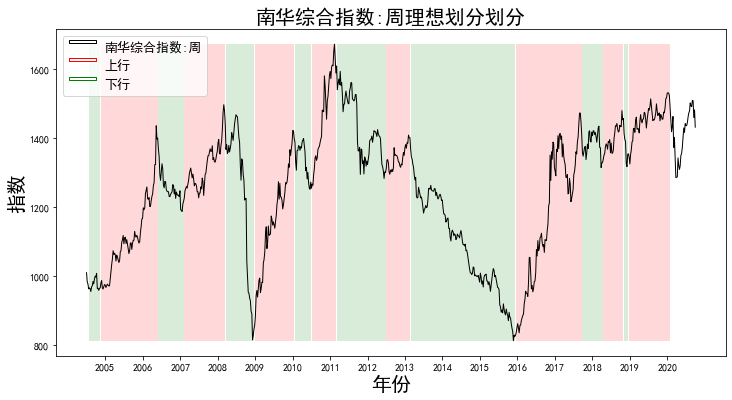

南华综合指数:周复杂度 2.03


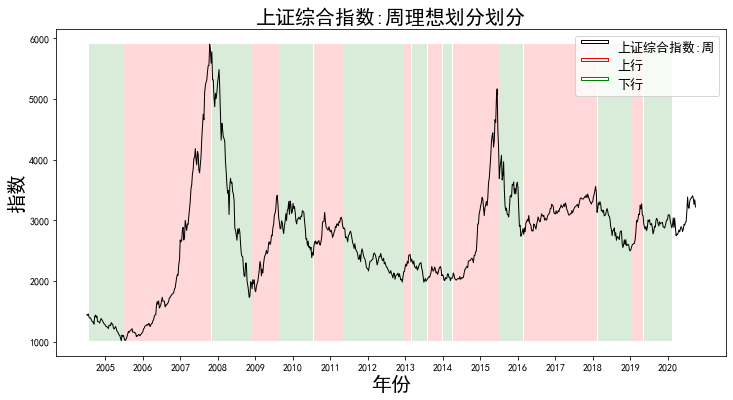

上证综合指数:周复杂度 2.15


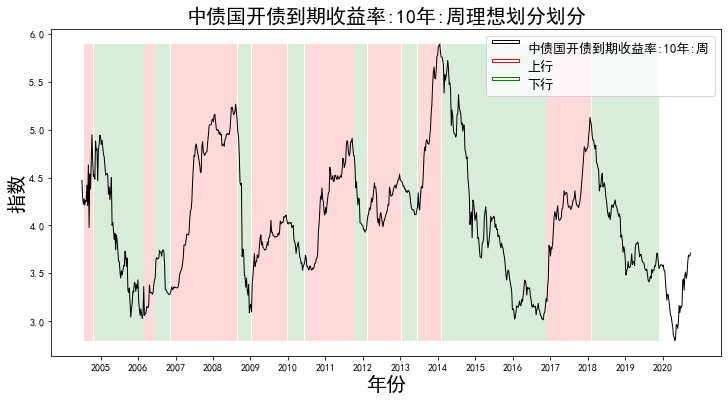

中债国开债到期收益率:10年:周复杂度 2.03


In [25]:
#理想趋势划分可视化

for ii in range(len(data)):
    supa_plot(d_w, eval('ud' + str(ii)), ii, '理想划分')
    exec('bc' + str(ii) + '= round( cpx(ud'+str(ii)+')  *100  ,  2    )  ')
    print(list(d_w)[ii]+'复杂度', eval('bc' + str(ii)))

## 移动平均（参照）

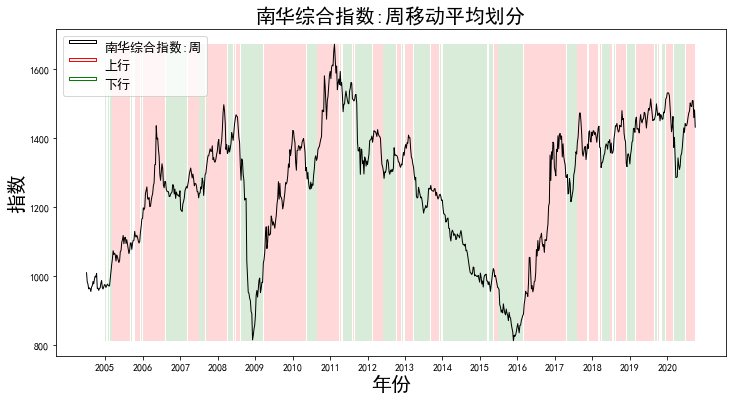

南华综合指数:周 移动平均 准确率 69.0 %
南华综合指数:周 移动平均 相对复杂度 4.35


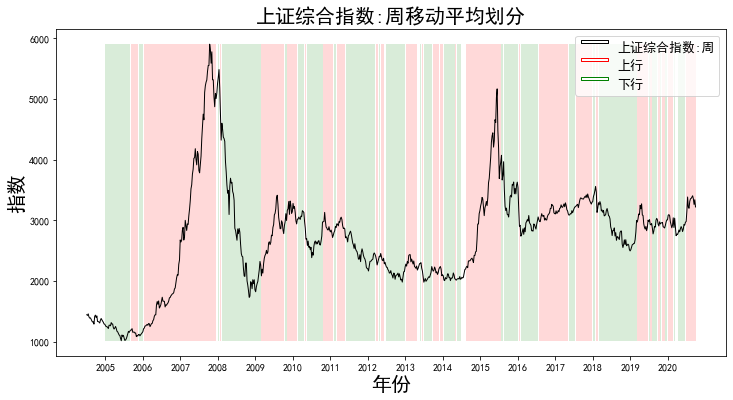

上证综合指数:周 移动平均 准确率 73.0 %
上证综合指数:周 移动平均 相对复杂度 3.88


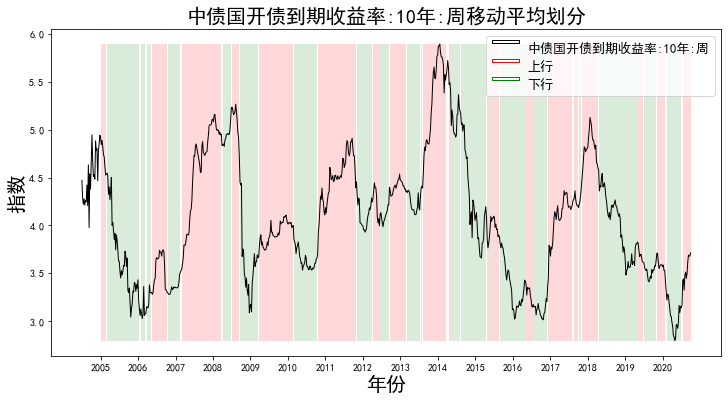

中债国开债到期收益率:10年:周 移动平均 准确率 73.0 %
中债国开债到期收益率:10年:周 移动平均 相对复杂度 3.08


In [26]:
m_name = '移动平均'
for ii in range(len(data)):
    data_ma = ma(data[ii],l)
    ud_ma = comp(data[ii][l-1:],data_ma)
    
    supa_plot(d_w, ud_ma, ii, m_name)
    
    c += 1
    
    exec('a' + str(c) + '= 100*acc(ud_ma[:len(ud'+str(ii)+'[l-1:ud'+str(ii)+'.index(0)])],ud'+str(ii)+'[l-1:ud'+str(ii)+'.index(0)])')
    exec('c' + str(c) + '= round(cpx(ud_ma)*100/bc'+str(ii)+',2)')
    
    print(list(d_w)[ii], m_name,'准确率', eval('a'+str(c)),'%')
    print(list(d_w)[ii], m_name,'相对复杂度', eval('c'+str(c)))
    
    name.append(m_name+list(d_w)[ii])

## 决策树

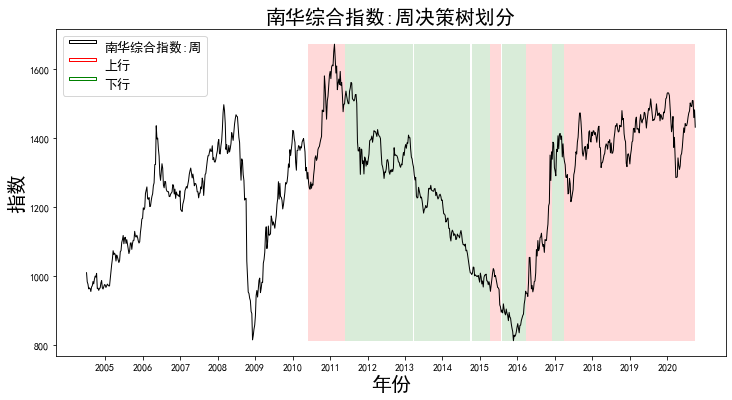

南华综合指数:周 准确率 72.0 %
南华综合指数:周 相对复杂度 1.01


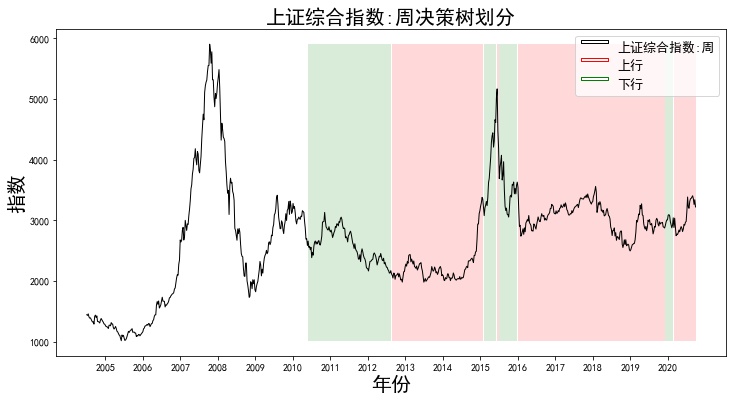

上证综合指数:周 准确率 61.0 %
上证综合指数:周 相对复杂度 0.69


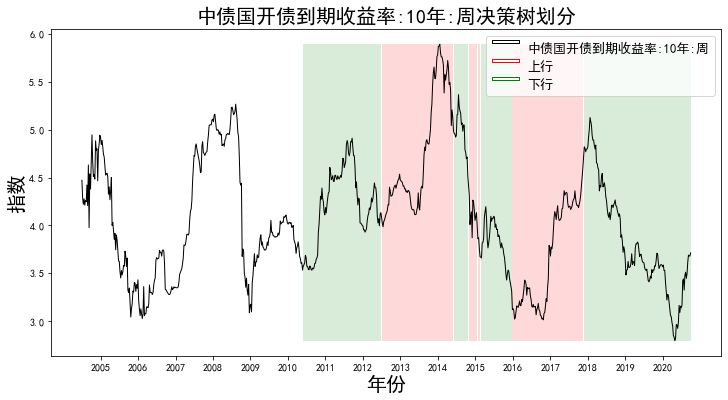

中债国开债到期收益率:10年:周 准确率 59.0 %
中债国开债到期收益率:10年:周 相对复杂度 0.82


In [27]:
m_name = '决策树'
tr = DecisionTreeClassifier()
for ii in range(len(data)):
    data_bond = [i[ii*L:(ii+1)*L] for i in df]
    tr_prd = []
    fud = und(data[ii][:start+1], w_fast, w_slow)[l-1:-w_slow][0]
    for i in range(start,len(date)):
        cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
        l_ud = len(cur_ud)        
        cur_tar = tar(cur_ud)
        tr.fit(  data_bond[:l_ud] ,  cur_tar)
        tr_res = tr.predict(  [data_bond[i-l+1]]  )[0]
        tr_prd.append(tr_res)

    _res = t2t(tr_prd,cur_ud[0])
    
    supa_plot(d_w, _res, ii, m_name)
    
    c += 1
    
    temp_l = len(_res[:-w_slow])
    
    exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
    exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
    
    print(list(d_w)[ii],'准确率', eval('a'+str(c)),'%')
    print(list(d_w)[ii],'相对复杂度', eval('c'+str(c)))
    
    name.append(m_name+list(d_w)[ii])

## 随机森林

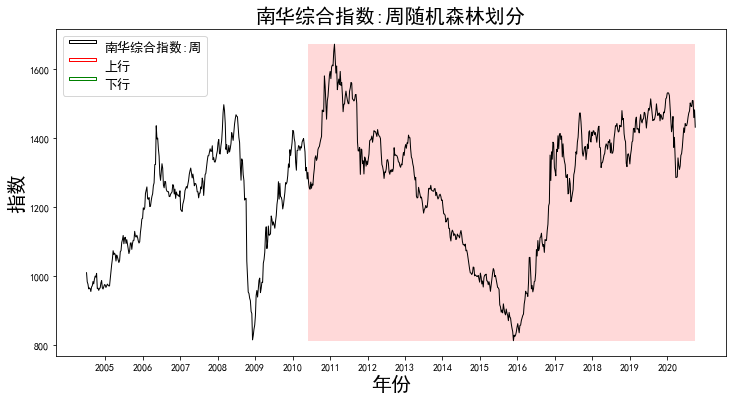

南华综合指数:周 准确率 48.0 %
南华综合指数:周 相对复杂度 0.09


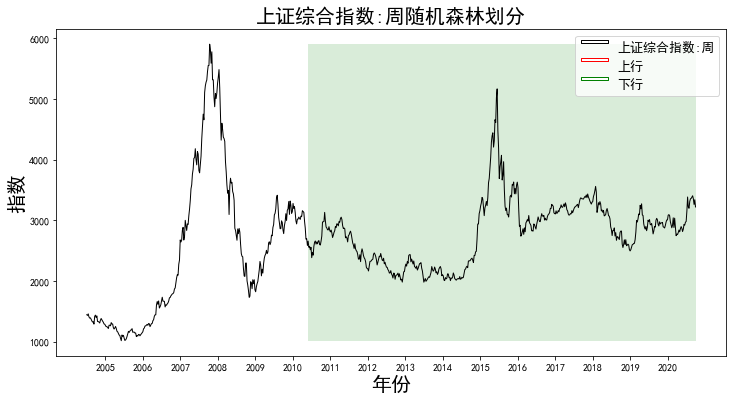

上证综合指数:周 准确率 48.0 %
上证综合指数:周 相对复杂度 0.09


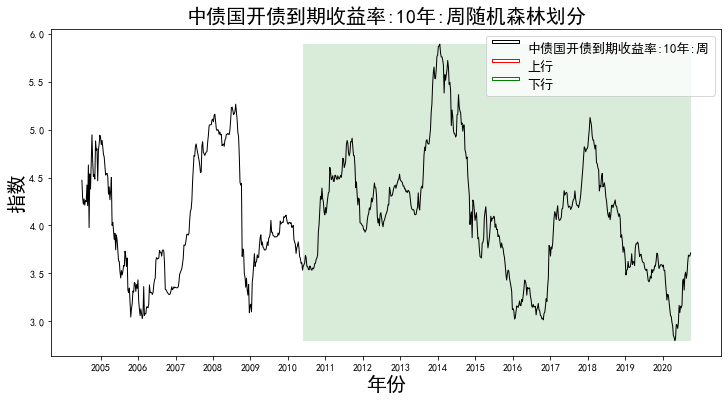

中债国开债到期收益率:10年:周 准确率 56.00000000000001 %
中债国开债到期收益率:10年:周 相对复杂度 0.09


In [28]:
m_name = '随机森林'
rf = RandomForestRegressor(n_estimators = 5)
for ii in range(len(data)):
    data_bond = [i[ii*L:(ii+1)*L] for i in df]
    rf_prd = []
    fud = und(data[ii][:start+1], w_fast, w_slow)[l-1:-w_slow][0]
    for i in range(start,len(date)):
        cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
        l_ud = len(cur_ud)        
        cur_tar = tar(cur_ud)
        rf.fit(  data_bond[:l_ud] ,  cur_tar)
        rf_res = rf.predict(  [data_bond[i-l+1]]  )[0]
        rf_prd.append(tr_res)

    _res = t2t(rf_prd,cur_ud[0])
    
    supa_plot(d_w, _res, ii, m_name)
    
    c += 1
    
    temp_l = len(_res[:-w_slow])
    
    exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
    exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
    
    print(list(d_w)[ii],'准确率', eval('a'+str(c)),'%')
    print(list(d_w)[ii],'相对复杂度', eval('c'+str(c)))
    
    name.append(m_name+list(d_w)[ii])

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller as ADF
from pandas import Series
from scipy.stats import norm

def sens_slope_trend_detection(inputdata,conf_level=0.95):
    inputdata = Series(inputdata)
    n  = inputdata.shape[0]
    t  = inputdata.value_counts()
    tadjs = sum(t * (t - 1) * (2 * t + 5))
    varS = (n * (n - 1) * (2 * n + 5) - tadjs)/18
    k = 0
    d = []
    for i in range(n-1):
        for j in range(i+1,n):
            k = k+1
            d.append((inputdata[j] - inputdata[i])/(j - i))
    b_sen = np.median(d)
    C = norm.ppf(1 - (1 - conf_level)/2) * np.sqrt(varS)
    rank_up = int(round((k + C)/2 + 1))
    rank_lo = int(round((k - C)/2))
    rank_d = sorted(d)
    lo = rank_d[rank_lo - 1]
    up = rank_d[rank_up - 1]
    S = 0
    for m in range(n):
        S = S + np.sum(np.sign(inputdata[m] - inputdata[0:m+1]))
    sg = np.sign(S)
    z = sg * (np.abs(S) - 1)/np.sqrt(varS)
    pval = 2 * min(0.5, 1-norm.cdf(np.abs(z)))
    return b_sen,z,pval

def trend_desc(inputdata):
    # 计算总趋势秩次和
    inputdata = np.array(inputdata)
    n = inputdata.shape[0]
    sum_sgn = 0
    for i in np.arange(n):
        if i <= (n - 1):
            for j in np.arange(i+1,n):
                if inputdata[j] > inputdata[i]:
                    sum_sgn = sum_sgn+1
                elif inputdata[j] < inputdata[i]:
                    sum_sgn = sum_sgn-1
                else:
                    sum_sgn = sum_sgn
    # 计算Z统计值
    if n <= 10:
        Z_value = sum_sgn/(n*(n-1)/2)
    else:
        if sum_sgn > 0:
            Z_value = (sum_sgn-1)/np.sqrt(n*(n-1)*(2*n+5)/18)
        elif sum_sgn == 0:
            Z_value = 0
        else:
            Z_value = (sum_sgn+1)/np.sqrt(n*(n-1)*(2*n+5)/18)
    # 时序平稳性检验之ADF检验（数据不易太少）
    ADF_result = ADF(inputdata,0)
    # 趋势描述
    # 99% ——> +—2.576
    # 95% ——> +—1.96
    # 90% ——> +—1.645
    if ADF_result[1]<0.01:
        result_desc = '呈现稳定趋势'
    else:
        if np.abs(Z_value) > 1.96 and np.abs(Z_value) <= 2.576:
            if Z_value > 0:
                result_desc = '呈现上升趋势'
        else:
                result_desc = '呈现下降趋势'
        if np.abs(Z_value) > 2.576:
            if Z_value > 0:
                result_desc = '呈现明显上升趋势'
            else:
                result_desc = '呈现明显下降趋势'
        else:
            result_desc     = '上升/下降趋势不明显'
    return result_desc


def Pettitt_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    n         = inputdata.shape[0]
    k = range(n)
    inputdataT = pd.Series(inputdata)
    r = inputdataT.rank()
    Uk = [2*np.sum(r[0:x])-x*(n + 1) for x in k]
    Uka = list(np.abs(Uk))
    U = np.max(Uka)
    K = Uka.index(U)
    pvalue         = 2 * np.exp((-6 * (U**2))/(n**3 + n**2))
    if pvalue <= 0.05:
        change_point_desc = '显著'
    else:
        change_point_desc = '不显著'
    Pettitt_result = {'突变点位置':K,'突变程度':change_point_desc}
    return K ,Pettitt_result

def SNHT_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    inputdata_mean = np.mean(inputdata)
    n  = inputdata.shape[0]
    k = range(1,n)
    sigma = np.sqrt(np.sum((inputdata-np.mean(inputdata))**2)/(n-1))
    Tk = [x*(np.sum((inputdata[0:x]-inputdata_mean)/sigma)/x)**2 + (n-x)*(np.sum((inputdata[x:n]-inputdata_mean)/sigma)/(n-x))**2 for x in k]
    T = np.max(Tk)
    K = list(Tk).index(T) + 1
    return K

def Buishand_U_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    inputdata_mean = np.mean(inputdata)
    n  = inputdata.shape[0]
    k = range(n)
    Sk = [np.sum(inputdata[0:x+1] - inputdata_mean) for x in k]
    sigma = np.sqrt(np.sum((inputdata-np.mean(inputdata))**2)/(n-1))
    U = np.sum((Sk[0:(n - 2)]/sigma)**2)/(n * (n + 1))
    Ska = np.abs(Sk)
    S = np.max(Ska)
    K = list(Ska).index(S) + 1
    Skk = (Sk/sigma)
    return K

def Kendall_change_point_detection(inputdata):
    inputdata = np.array(inputdata)
    n=inputdata.shape[0]
    # 正序列计算---------------------------------
    # 定义累计量序列Sk，初始值=0
    Sk             = [0]
    # 定义统计量UFk，初始值 =0
    UFk            = [0]
    # 定义Sk序列元素s，初始值 =0
    s              =  0
    Exp_value      = [0]
    Var_value      = [0]
    # i从1开始，因为根据统计量UFk公式，i=0时，Sk(0)、E(0)、Var(0)均为0
    # 此时UFk无意义，因此公式中，令UFk(0)=0
    for i in range(1,n):
        for j in range(i):
            if inputdata[i] > inputdata[j]:
                s = s+1
            else:
                s = s+0
        Sk.append(s)
        Exp_value.append((i+1)*(i+2)/4 )                     # Sk[i]的均值
        Var_value.append((i+1)*i*(2*(i+1)+5)/72 )            # Sk[i]的方差
        UFk.append((Sk[i]-Exp_value[i])/np.sqrt(Var_value[i]))
    # ------------------------------正序列计算
    # 逆序列计算---------------------------------
    # 定义逆序累计量序列Sk2，长度与inputdata一致，初始值=0
    Sk2             = [0]
    # 定义逆序统计量UBk，长度与inputdata一致，初始值=0
    UBk             = [0]
    UBk2            = [0]
    # s归0
    s2              =  0
    Exp_value2      = [0]
    Var_value2      = [0]
    # 按时间序列逆转样本y
    inputdataT = list(reversed(inputdata))
    # i从2开始，因为根据统计量UBk公式，i=1时，Sk2(1)、E(1)、Var(1)均为0
    # 此时UBk无意义，因此公式中，令UBk(1)=0
    for i in range(1,n):
        for j in range(i):
            if inputdataT[i] > inputdataT[j]:
                s2 = s2+1
            else:
                s2 = s2+0
        Sk2.append(s2)
        Exp_value2.append((i+1)*(i+2)/4 )                     # Sk[i]的均值
        Var_value2.append((i+1)*i*(2*(i+1)+5)/72 )            # Sk[i]的方差
        UBk.append((Sk2[i]-Exp_value2[i])/np.sqrt(Var_value2[i]))
        UBk2.append(-UBk[i])
    # 由于对逆序序列的累计量Sk2的构建中，依然用的是累加法，即后者大于前者时s加1，
    # 则s的大小表征了一种上升的趋势的大小，而序列逆序以后，应当表现出与原序列相反
    # 的趋势表现，因此，用累加法统计Sk2序列，统计量公式(S(i)-E(i))/sqrt(Var(i))
    #也不应改变，但统计量UBk应取相反数以表征正确的逆序序列的趋势
    #  UBk(i)=0-(Sk2(i)-E)/sqrt(Var)
    # ------------------------------逆序列计算
    # 此时上一步的到UBk表现的是逆序列在逆序时间上的趋势统计量
    # 与UFk做图寻找突变点时，2条曲线应具有同样的时间轴，因此
    # 再按时间序列逆转结果统计量UBk，得到时间正序的UBkT，
    UBkT = list(reversed(UBk2))
    diff = np.array(UFk) - np.array(UBkT)
    K    = list()
    # 找出交叉点
    for k in range(1,n):
        if diff[k-1]*diff[k]<0:
            K.append(k)
    # 做突变检测图时，使用UFk和UBkT
    plt.figure(figsize=(12,6))
    plt.plot(range(1,n+1) ,UFk  ,label='UFk') # UFk
    plt.plot(range(1,n+1) ,UBkT ,label='UBk') # UBk
    plt.ylabel('UFk-UBk')
    x_lim = plt.xlim()
    plt.plot(x_lim,[-1.96,-1.96],'m--',color='r')
    plt.plot(x_lim,[  0  ,  0  ],'m--')
    plt.plot(x_lim,[+1.96,+1.96],'m--',color='r')
    plt.legend(loc=2) # 图例
    plt.show()
    return K

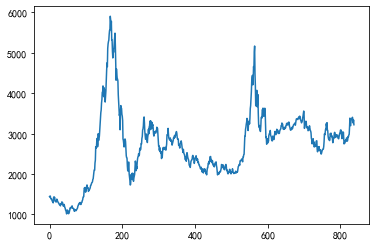

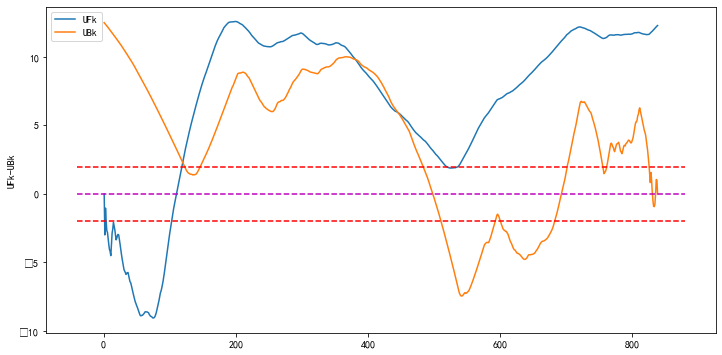

Mann-Kendall: [119, 381, 445]
Pettitt: (537, {'突变点位置': 537, '突变程度': '显著'})
Buishand U Test: 130
Standard Normal Homogeneity Test (SNHT): 125


In [45]:
dt = data[1]
plt.plot(dt)

print("Mann-Kendall:",Kendall_change_point_detection(dt))
print("Pettitt:",Pettitt_change_point_detection(dt))
print("Buishand U Test:",Buishand_U_change_point_detection(dt))
print("Standard Normal Homogeneity Test (SNHT):",SNHT_change_point_detection(dt))